# Custom Modelling with BIRDMAn - Paired Data with SingleFeatureModels

One of the primary goals of BIRDMAn is to allow users to develop and implement their own statistical models based on their experimental design/question. For example, if you have paired or longitudinal data, you would likely want to specify random intercepts for individual subjects.

Here, we will do a fairly in-depth walkthrough of how you can use BIRDMAn to analyze paired data. Additionally, w will show off how to fit single microbes through BIRDMAn rather than the full table.

## Data description

We will be using data from the study "Linking the effects of helminth infection, diet and the gut microbiota with human whole-blood signatures (repeated measurements)" (Qiita ID: 11913). This study looks at the effect of de-worming on the gut microbiome. Importantly, they collected pre and post-deworming stool samples on several individuals.

For our purposes, we would like to consider a linear mixed effects model (LME) where de-worming timepoint is a fixed effect and subject ID is a random effect. We will first process and explore the raw data.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import biom
import numpy as np
import pandas as pd
import birdman

plt.style.use("./plot.mplstyle")

In [3]:
raw_tbl = biom.load_table("../data/helminth/94270_reference-hit.biom")
raw_tbl

2948 x 56 <class 'biom.table.Table'> with 8935 nonzero entries (5% dense)

In [4]:
metadata = pd.read_csv("../data/helminth/11913_20191016-112545.txt", sep="\t", index_col=0)
metadata.head()

,age,ascaris,collection_device,collection_method,collection_timestamp,date_of_collection,description,dna_extracted,elevation,elevation_units,...,sample_well,scientific_name,sex,site,taxon_id,time_point,title,trichuris,tube_id,villageaf
sample_name,,,,,,,,,,,,,,,,,,,,,
11913.101,15.0,0.0,Plastic container,By study subject,2013-05-08,May_13,"Selangor, Rural Indigenous, Stool samples",True,not collected,meters,...,p03.C11,human gut metagenome,female,HumanGut,408170,1,"Linking the effects of helminth infection, die...",1.0,101,BF
11913.101AF,15.0,0.0,Plastic container,By study subject,2013-06-02,Jun_13,"Selangor, Rural Indigenous, Stool samples",True,not collected,meters,...,p01.E7,human gut metagenome,female,HumanGut,408170,1,"Linking the effects of helminth infection, die...",1.0,101AF,AF
11913.102,50.0,0.0,Plastic container,By study subject,2013-05-08,May_13,"Selangor, Rural Indigenous, Stool samples",True,not collected,meters,...,p03.C12,human gut metagenome,female,HumanGut,408170,1,"Linking the effects of helminth infection, die...",1.0,102,BF
11913.102AF,50.0,0.0,Plastic container,By study subject,2013-06-02,Jun_13,"Selangor, Rural Indigenous, Stool samples",True,not collected,meters,...,p01.E8,human gut metagenome,female,HumanGut,408170,2,"Linking the effects of helminth infection, die...",1.0,102AF,AF
11913.103AF,NaN,NaN,Plastic container,By study subject,2013-06-02,NaN,"Selangor, Rural Indigenous, Stool samples",True,not collected,meters,...,NaN,human gut metagenome,female,NaN,408170,2,"Linking the effects of helminth infection, die...",NaN,103AF,NaN


First, we want to determine which subjects have paired samples (taken at `time_point` 1 and 2).

In [5]:
metadata["host_subject_id"].unique()

array([  101,   102,   103,  1097,   119,  1248,  1259,  1287,   135,
        1372,  1383,   145, 15104,  1533,  1612,   166,  1719,  1758,
         181,  1875,  1889,  1892, 19100,  1998,  1999, 20109,  2093,
         218,   220,   221,   351,    37,   442,   445,   463,   511,
        5112,  5113,    52,   634,   762,   780,  8107,    88,   930,
         941,   953,    96,   969,    98,   995])

In [6]:
subj_is_paired = metadata.groupby("host_subject_id").apply(lambda x: (x["time_point"].values == [1, 2]).all())
paired_subjs = subj_is_paired[subj_is_paired].index
paired_subjs

Int64Index([   37,    52,    96,   102,   119,   135,   145,   166,   181,
              218,   220,   221,   351,   445,   463,   511,   780,   930,
              941,   953,  1097,  1248,  1259,  1383,  1533,  1612,  1719,
             1875,  1998,  8107, 19100, 20109],
           dtype='int64', name='host_subject_id')

In [7]:
paired_samps = metadata[metadata["host_subject_id"].isin(paired_subjs)].index

For this example we will consider only post/pre-deworm status.

In [8]:
cols_to_keep = ["time_point", "host_subject_id"]
metadata_model = metadata.loc[paired_samps, cols_to_keep].dropna()

Additionally, we are going to change the encoding of `time_point` to be more explicit. We are also going to prefix each subject ID with "S" so that they are read as strings instead of integers.

In [9]:
metadata_model["time_point"] = metadata_model["time_point"].map({1: "pre-deworm", 2: "post-deworm"})
metadata_model["host_subject_id"] = "S" + metadata["host_subject_id"].astype(str)

In [10]:
metadata_model.head()

,time_point,host_subject_id
sample_name,,
11913.102,pre-deworm,S102
11913.102AF,post-deworm,S102
11913.1097,pre-deworm,S1097
11913.1097AF,post-deworm,S1097
11913.119,pre-deworm,S119


## Filtering the feature table

We want to filter the original BIOM table to include only the samples we've specified. We are also going to reduce the number of microbes in the table to a more manageable number for this demonstration.

In [11]:
raw_tbl_df = raw_tbl.to_dataframe()
raw_tbl_df.iloc[:5, :5]

,11913.20109AF,11913.1383AF,11913.1097,11913.101AF,11913.634AF
TACGGAGGGTGCAAGCGTTAATCGGAATAACTGGGCGTAAAGGGCATGCAGGCGGTTCATCAAGTAGGATGTGAAATCCCCGGGCTCAAC,995.0,4355.0,1811.0,28.0,3229.0
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGCGTGTTGTGAAATGTAGACGCTCAAC,917.0,3345.0,516.0,827.0,5260.0
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGCGTGTTGTGAAATGTAGATGCTCAAC,737.0,1761.0,273.0,1298.0,5845.0
AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCCATGGGCTCAAC,204.0,545.0,71.0,305.0,918.0
TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGTGCGGCAAGTCTGATGTGAAAGCCCGGGGCTCAAC,122.0,79.0,573.0,321.0,246.0


In [12]:
samps_to_keep = sorted(list(set(raw_tbl_df.columns).intersection(metadata_model.index)))
len(samps_to_keep)

46

To filter out features, we calculate the prevalence of each feature and keep only features that appear in at least 25 samples out of 46.

In [13]:
filt_tbl_df = raw_tbl_df.loc[:, samps_to_keep]
prev = filt_tbl_df.clip(upper=1).sum(axis=1)
filt_tbl_df = filt_tbl_df.loc[prev[prev >= 25].index, :]
filt_tbl_df.shape

(65, 46)

Now we save this DataFrame as a BIOM so we can pass it into BIRDMAn.

In [14]:
filt_tbl = biom.table.Table(
    filt_tbl_df.values,
    sample_ids=filt_tbl_df.columns,
    observation_ids=filt_tbl_df.index
)
filt_tbl

65 x 46 <class 'biom.table.Table'> with 2239 nonzero entries (74% dense)

## LME Model

We have provided a Stan file with the code required to run this model. First, we'll print the contents to the screen.

In [15]:
with open("../models/negative_binomial_single_re.stan", "r") as f:
    print(f.read())

data {
  int<lower=1> N;
  real A;
  int<lower=1> p;
  array[N] real depth;
  array[N] int y;
  matrix[N, p] x;
  real<lower=0> B_p;
  real<lower=0> disp_scale;

  // Random Effects
  int<lower=1> num_subjs;
  array[N] int<lower=1, upper=num_subjs> subj_map;
  real<lower=0> re_p;
}

parameters {
  real<offset=A, multiplier=3> beta_0;
  vector[p-1] beta_x;
  real<lower=0> reciprocal_phi;
  vector[num_subjs] subj_re;  // Subject effect on intercept
}

transformed parameters {
  vector[p] beta_var = append_row(beta_0, beta_x);
  vector[N] lam;
  real phi = inv(reciprocal_phi);

  for (n in 1:N) {
    lam[n] = depth[n];
    for (i in 1:p) {
      // when i = 1 -> Intercept (1)
      // Add subj effect
      lam[n] = lam[n] + (beta_var[i] + subj_re[subj_map[n]]) * x[n, i];
    }
  }
}

model {
  beta_0 ~ normal(A, 3);
  beta_x ~ normal(0, B_p);
  reciprocal_phi ~ lognormal(0, disp_scale);
  subj_re ~ normal(0, re_p);

  y ~ neg_binomial_2_log(lam, phi);
}

generated quantities {
  vector[N]

### Description of the model

The basic Negative Binomial model for a single microbe is as follows:

$$ y_{ij} \sim \mathrm{NB}(\mu_{ij},\phi_j) $$

$$ \ln(\mu_{ij}) = X_i \beta_{j} + \ln(\mathrm{Depth}_i)$$

where $i$ is an arbitrary sample, $j$ is an arbitrary microbe, $n$ is the sampling depth, and $\phi$ is the dispersion parameter.

For the default NB model, the probability for each microbe in a given sample is a function of only the fixed-effects. $X_i$ is the covariate matrix of sample $i$ and $\beta$ is the covariate coefficient vector (e.g. $[\beta_{\rm{Intercept}}, \beta_{\rm{Time}}, ...]^T$).

To include a random effect, we add a random intercept for each subject ID.

$$ \ln(\mu_{ij}) = X_i \beta_{j} + \ln(\mathrm{Depth}_i) + z_i u_{jk} $$

where $z_i$ is the mapping of sample $i$ to subject $k$ and $u$ is the subject coefficient vector (e.g. $[u_{\textrm{S1}}, u_{\textrm{S2}}, ...]$)

We will first compile this model manually. The reason we do this is so that if we are running multiple microbes in parallel, we don't run into issues where multiple processes are trying to compile the same file simultaneously.

In [16]:
import cmdstanpy
cmdstanpy.CmdStanModel(stan_file="../models/negative_binomial_single_re.stan")

CmdStanModel: name=negative_binomial_single_re
	 stan_file=/home/grahman/projects/BIRDMAn-demo/models/negative_binomial_single_re.stan
	 exe_file=/home/grahman/projects/BIRDMAn-demo/models/negative_binomial_single_re
	 compiler_options=stanc_options={}, cpp_options={}

Next, we'll define a custom class that inherits `birdman.SingleFeatureModel`. We will go through the components in this class to describe what each block is doing.

In [17]:
class NBPairedSingle(birdman.SingleFeatureModel):
    def __init__(
        self,
        table: biom.Table,
        feature_id: str,
        formula: str,
        metadata: pd.DataFrame,
        num_iter: int = 100,
        num_warmup: int = 500,
        chains: int = 4,
        beta_prior: float = 3.0,
        subj_prior: float = 2.0,
        disp_scale: float = 0.5,
        **kwargs
    ):  
        super().__init__(
            table=table,
            feature_id=feature_id,
            model_path="../models/negative_binomial_single_re.stan",
            num_iter=num_iter,
            num_warmup=num_warmup,
        )

        subj_series = metadata["host_subject_id"].loc[self.sample_names]
        samp_subj_map = subj_series.astype("category").cat.codes + 1
        self.subjects = np.sort(subj_series.unique())

        self.create_regression(formula, metadata)

        D = table.shape[0]
        A = np.log(1 / D)

        param_dict = {
            "depth": np.log(table.sum(axis="sample")),
            "num_subjs": len(self.subjects),
            "subj_map": samp_subj_map.values,
            "B_p": beta_prior,
            "disp_scale": disp_scale,
            "re_p": subj_prior,
            "A": A
        }
        self.add_parameters(param_dict)

        self.specify_model(
            params=["beta_var", "phi", "subj_re"],
            dims={
                "beta_var": ["covariate"],
                "subj_re": ["subject"],
                "log_lhood": ["tbl_sample"],
                "y_predict": ["tbl_sample"]
            },
            coords={
                "covariate": self.colnames,
                "tbl_sample": self.sample_names,
                "subject": self.subjects
            },
            include_observed_data=True,
            posterior_predictive="y_predict",
            log_likelihood="log_lhood"
        )

## Class Arguments

In [18]:
model_iter = birdman.ModelIterator(
    table=filt_tbl,
    model=NBPairedSingle,
    metadata=metadata_model,
    formula="C(time_point, Treatment('pre-deworm'))",
    num_iter=100,
    beta_prior=3.0,
    subj_prior=2.0,
    disp_scale=0.5
)

In [19]:
import logging

cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

NOTE: Fitting should take about 1.5 minutes.

In [20]:
%%time
%%capture

inferences = []
for feature_id, model in model_iter:
    model.compile_model()
    model.fit_model()
    inf = model.to_inference()
    inferences.append(inf)

CPU times: user 6.84 s, sys: 2.62 s, total: 9.45 s
Wall time: 1min 36s


The above code block results in a list of `InferenceData` objects. Ideally we would like to concatenate all of these inferences together. BIRDMAn provides such a utility function in the `model_util` module.

We also want to mean center the coefficients due to compositionality. This is pretty easy in `xarray`!

In [21]:
from birdman.model_util import concatenate_inferences

inf_concat = concatenate_inferences(inferences, coords={"feature": filt_tbl.ids("observation")})

inf_concat.posterior["beta_var"] = (
    inf_concat.posterior["beta_var"] - inf_concat.posterior["beta_var"].mean(["chain", "draw", "feature"])
)

inf_concat.posterior["subj_re"] = (
    inf_concat.posterior["subj_re"] - inf_concat.posterior["subj_re"].mean(["chain", "draw", "feature"])
)

For this notebook we'll look at differential taxa by post-deworm status. First, we want to summarize the posterior distributions of each features. There are a couple ways we can do this, but we'll just take the mean and standard deviation of each feature distribution. BIRDMAn has a convenience function for this purpose. We need to tell BIRDMAn that we are specifically interested in the `post-deworm` covariate.

In [22]:
from birdman.summary import summarize_posterior

coords = {"covariate": "C(time_point, Treatment('pre-deworm'))[T.post-deworm]"}

deworm_mean = summarize_posterior(inf_concat.posterior, "beta_var", coords)
deworm_std = summarize_posterior(inf_concat.posterior, "beta_var", coords)

deworm_df = pd.concat([deworm_mean, deworm_std], axis=1)
deworm_df.columns = ["post_deworm_mean", "post_deworm_std"]
deworm_df = deworm_df.sort_values(by="post_deworm_mean", ascending=False)
deworm_df.head()

,post_deworm_mean,post_deworm_std
feature,,
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGTCTGGTAAGCGTGTTGTGAAATGTCGGGGCTCAAC,1.368741,1.368741
TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGGTGGCAAGGCAAGCCAGAAGTGAAAACCCGGGGCTCAAC,1.324558,1.324558
TACGGAGGGTGCAAGCGTTAATCGGAATAACTGGGCGTAAAGGGCATGCAGGCGGTTCATCAAGTAGGATGTGAAATCCCCGGGCTCAAC,1.233840,1.233840
TACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGTGTAGGTGGCCATGCAAGTCAGAAGTGAAAATCCGGGGCTCAAC,1.067045,1.067045
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGCGTGTTGTGAAATGTAGATGCTCAAC,1.046864,1.046864


Next, we'll take the top and bottom 10 microbes associated with post-deworm status to create per-sample log-ratios.

In [23]:
n = 10
bottom_feats = deworm_df.tail(n).index
top_feats = deworm_df.head(n).index

In [24]:
import numpy as np

def log_ratio(table, top_feats, bot_feats):
    num_df = table.loc[:, top_feats].sum(axis=1).to_frame()
    num_df.columns = ["num"]
    num_df = num_df[num_df["num"] > 0]
    denom_df = table.loc[:, bot_feats].sum(axis=1).to_frame()
    denom_df.columns = ["denom"]
    denom_df = denom_df[denom_df["denom"] > 0]
    lr_df = num_df.join(denom_df, how="inner")
    lr_df["log_ratio"] = np.log(lr_df["num"]/lr_df["denom"])
    return lr_df

lr_df = log_ratio(filt_tbl_df.T, top_feats, bottom_feats).join(metadata_model, how="inner")
print(lr_df.shape)
lr_df.head()

(46, 5)


,num,denom,log_ratio,time_point,host_subject_id
11913.102,2132.0,43.0,3.903616,pre-deworm,S102
11913.102AF,3226.0,145.0,3.102265,post-deworm,S102
11913.1097,2110.0,103.0,3.019714,pre-deworm,S1097
11913.1097AF,2489.0,31.0,4.385649,post-deworm,S1097
11913.1248,442.0,186.0,0.865563,pre-deworm,S1248


Because we have paired samples, we want to look at the differences from pre-deworm to post-deworm.

In [25]:
func = lambda x: (
    x.query("time_point == 'post-deworm'")["log_ratio"][0] 
    - x.query("time_point == 'pre-deworm'")["log_ratio"][0]
)

lr_diffs = (
    lr_df
    .groupby("host_subject_id")
    .apply(func)
)
lr_diffs.head()

host_subject_id
S102    -0.801351
S1097    1.365935
S1248    3.301400
S1259    0.373832
S1383    3.672885
dtype: float64

Finally, we'll plot the log-ratio changes from pre-deworm to post-deworm.

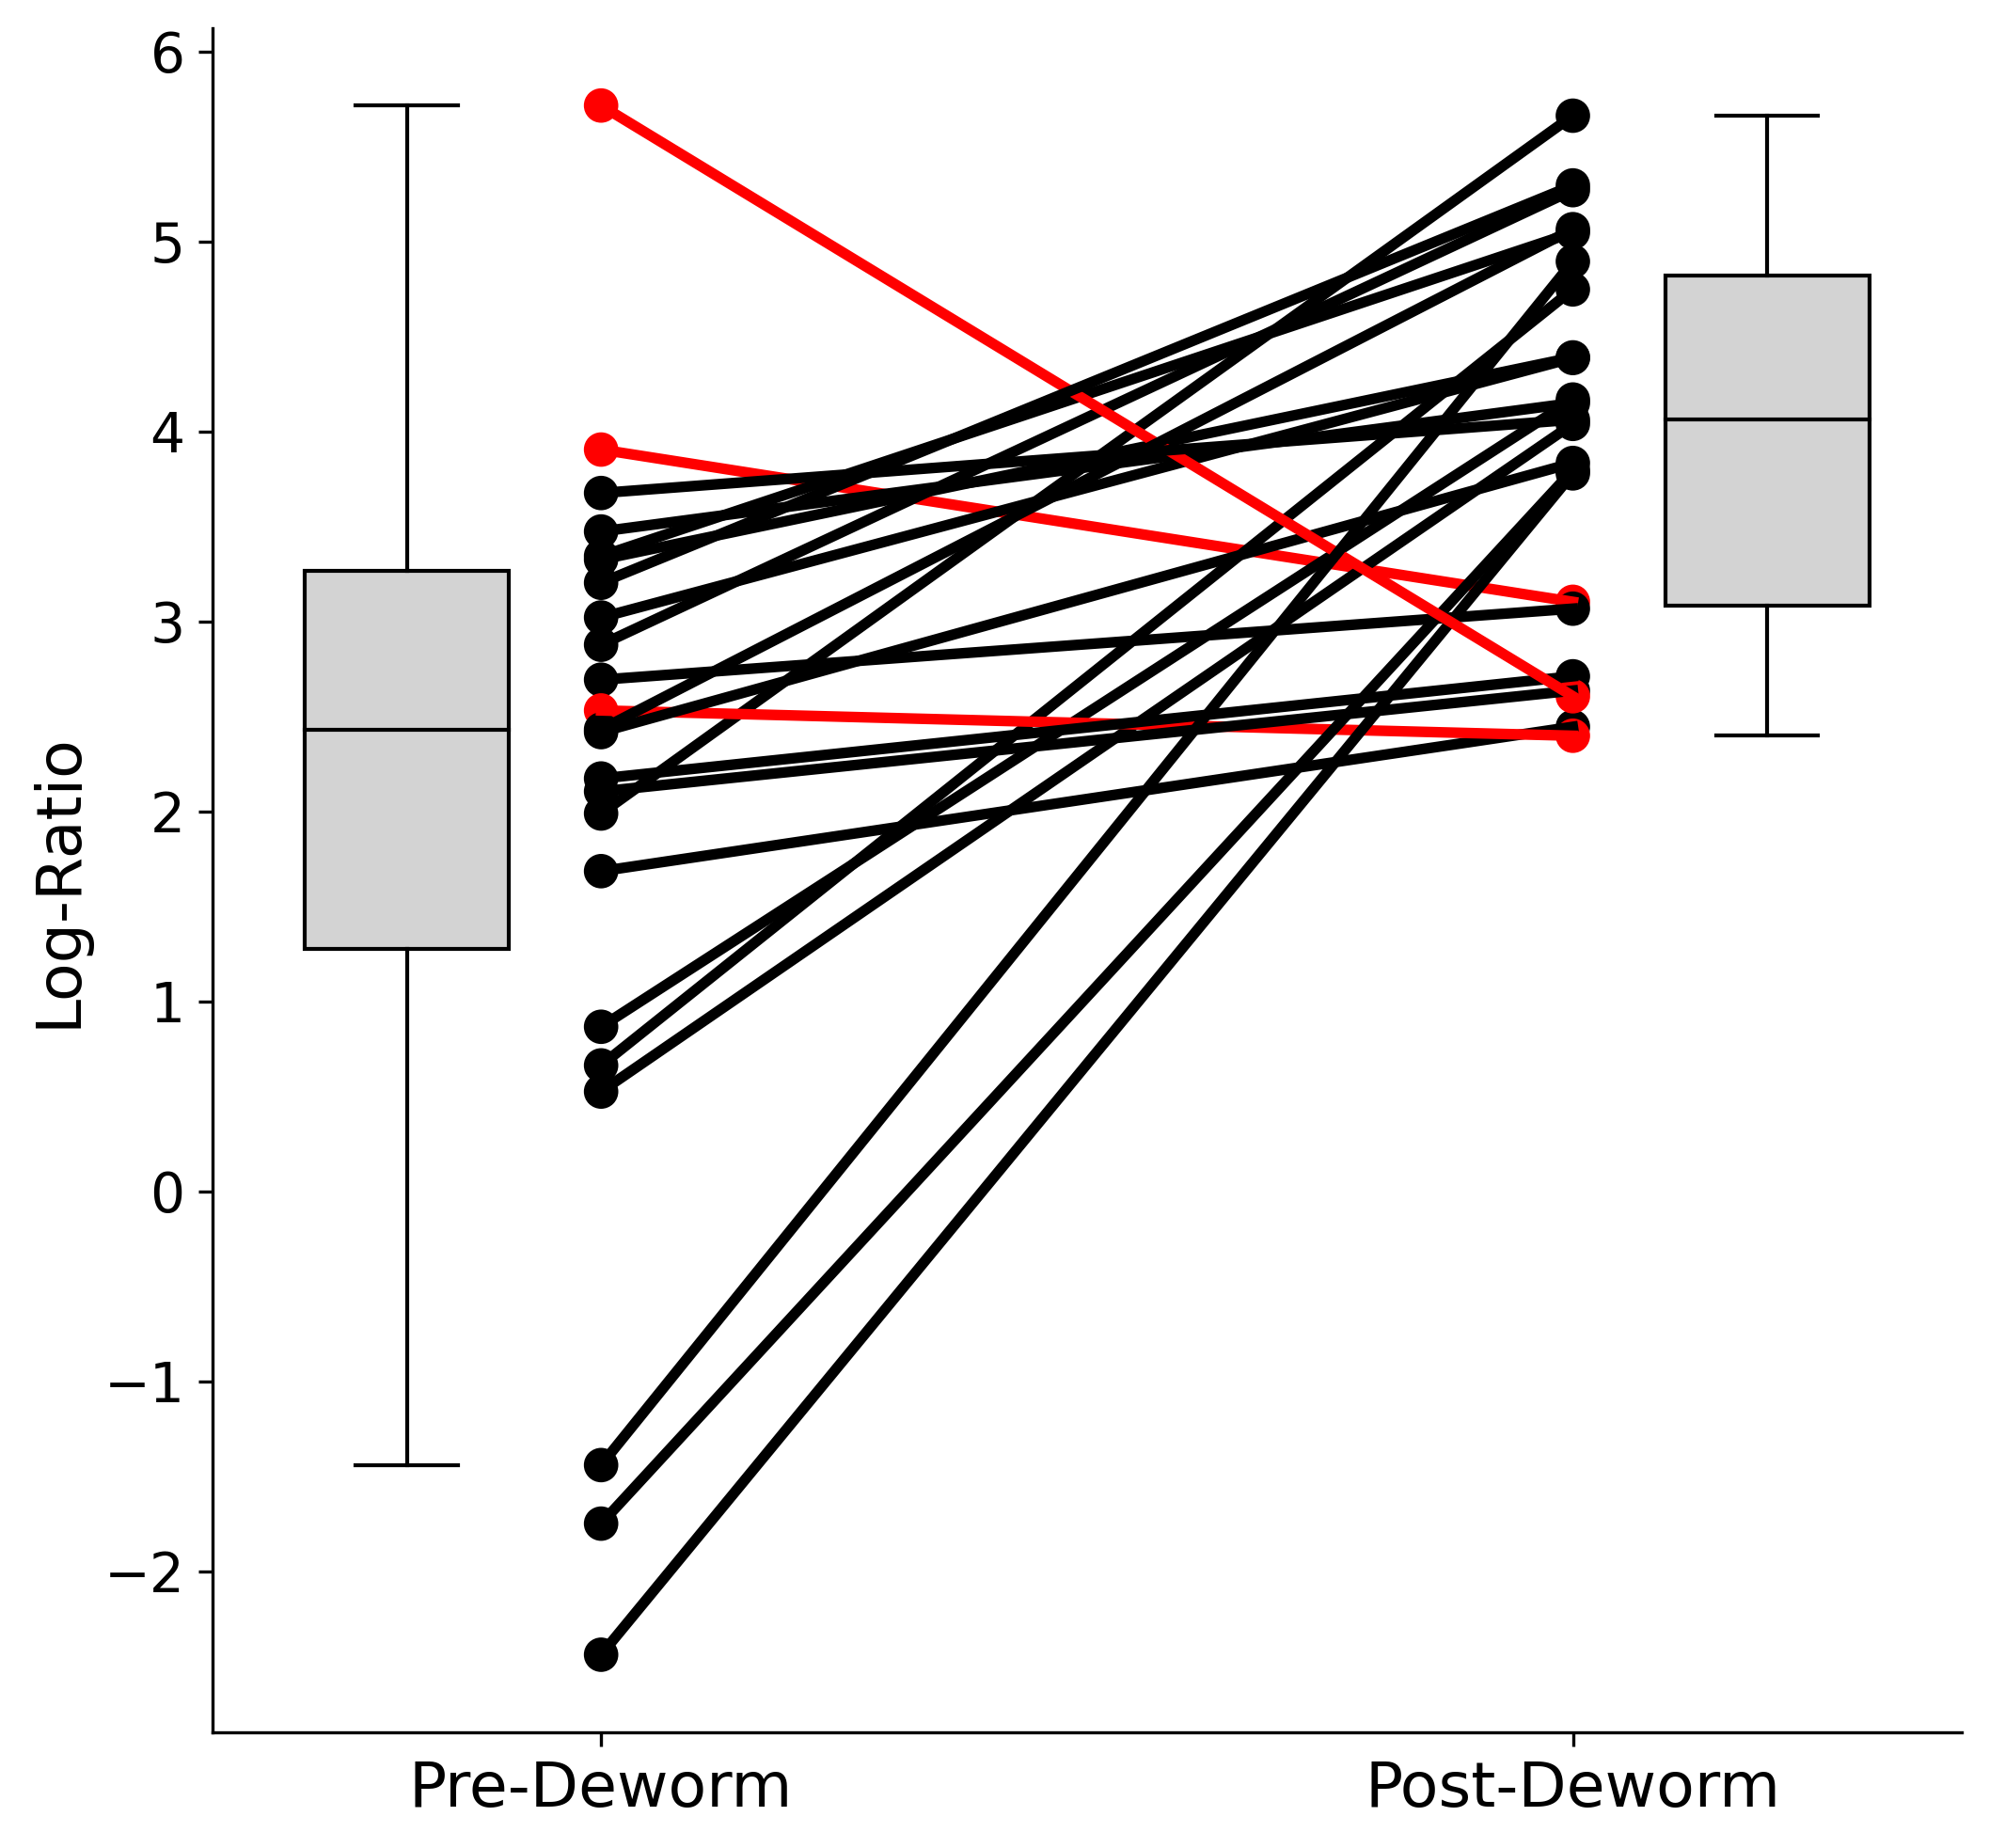

In [26]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 8))

for subj_id, subj_df in lr_df.groupby("host_subject_id"):
    _d = lr_diffs[subj_id]
    
    args = {
        "data": subj_df,
        "x": "time_point",
        "y": "log_ratio",
        "color": "black" if _d > 0 else "red",
    }
    sns.pointplot(**args, ax=ax)

ax.set_xlim([-0.4, 1.4])

pre_deworm_lrs = lr_df.query("time_point == 'pre-deworm'")["log_ratio"].values
post_deworm_lrs = lr_df.query("time_point == 'post-deworm'")["log_ratio"].values

bplot = ax.boxplot(
    [pre_deworm_lrs, post_deworm_lrs],
    positions=[-0.2, 1.2],
    patch_artist=True,
    showfliers=False
)

for patch in bplot["boxes"]:
    patch.set_facecolor("lightgray")
for med in bplot["medians"]:
    med.set_color("black")

    
ax.set_xticks([0, 1])
ax.set_xticklabels(["Pre-Deworm", "Post-Deworm"], fontsize=16)
ax.tick_params("y", labelsize=14)
ax.set_xlabel("")
ax.set_ylabel("Log-Ratio", fontsize=16)

plt.show()

In [27]:
import scipy.stats as ss

ss.wilcoxon(lr_diffs)

WilcoxonResult(statistic=25.0, pvalue=0.0002148151397705078)

We see that, indeed, this auto-selected log-ratio separates post-deworm from pre-deworm paired samples.

We may want to generate a rank plot summarizing the log-fold changes of all microbes. BIRDMAn has a simple function to visualize the sorted log-fold changes with the standard deviations as error bars.

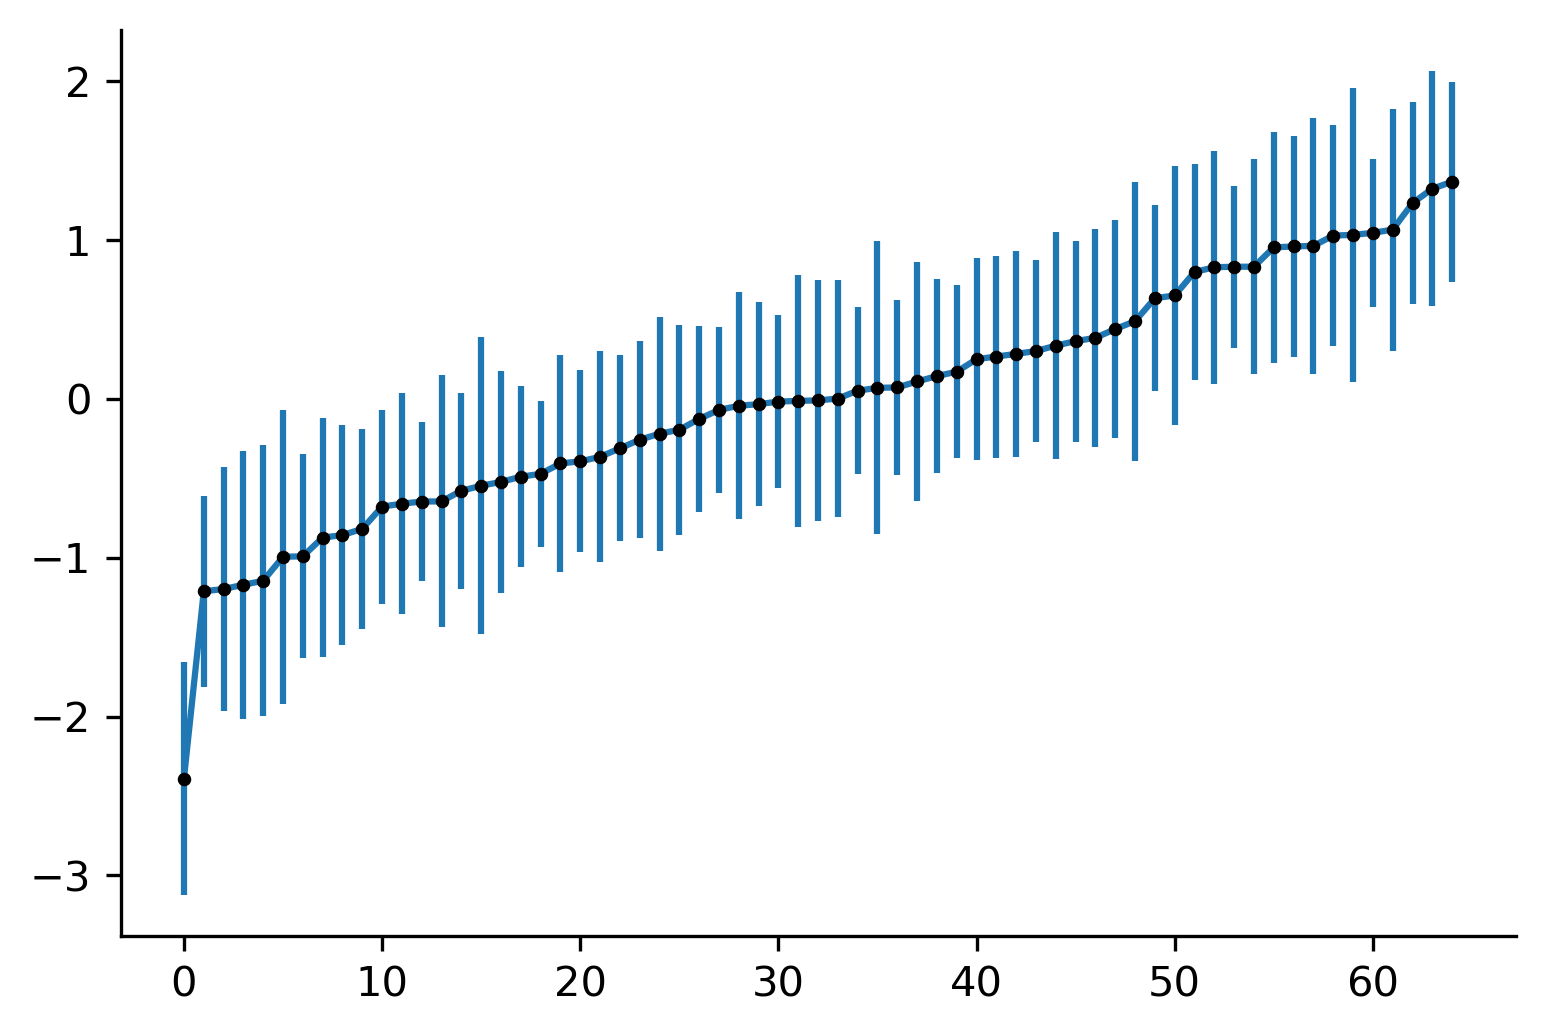

In [28]:
from birdman import visualization as viz

viz.plot_parameter_estimates(
    inf_concat,
    "beta_var",
    coords=coords,
    num_std=1  # Number of standard deviations to plot
);

So far this is very similar to what you could do with other differential abundance tools. Remember that we included the subject level effects as well! We can summarize these differentials in a similar way as the deworm status differentials.

In [29]:
subj_re_df = summarize_posterior(inf_concat.posterior, "subj_re")
subj_re_df.head()

subject,S102,S1097,S1248,S1259,S1383,S1533,S1612,S1719,S19100,S1998,...,S221,S351,S37,S445,S463,S511,S780,S930,S953,S96
feature,,,,,,,,,,,,,,,,,,,,,
TACGGAGGGTGCAAGCGTTAATCGGAATAACTGGGCGTAAAGGGCATGCAGGCGGTTCATCAAGTAGGATGTGAAATCCCCGGGCTCAAC,-1.507705,0.369061,-0.543341,-2.689872,0.827533,1.013385,0.206595,1.215848,-0.010188,0.037085,...,1.545671,-0.657633,-0.219805,0.180835,-2.037848,1.299663,1.009818,0.198065,1.100489,0.266816
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGCGTGTTGTGAAATGTAGACGCTCAAC,0.748216,0.085338,-0.269733,-1.298420,0.517194,1.229552,-0.545617,-0.201165,-0.244254,0.045168,...,0.331023,-0.506983,-0.573405,0.702037,0.305558,1.361021,0.015776,0.300960,0.991631,0.946283
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGCGTGTTGTGAAATGTAGATGCTCAAC,0.323448,-0.052525,-0.049939,0.399084,-0.077430,1.022092,-0.990644,-0.819817,-0.163476,0.142354,...,0.256360,-0.179118,-0.452383,0.344067,0.466715,1.298575,-0.252527,0.116617,0.787400,0.324611
AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCCATGGGCTCAAC,0.485864,0.124242,0.582437,-0.417812,0.149319,-0.570761,0.578297,0.487805,0.133136,0.349377,...,-4.387139,0.513691,0.168261,0.518822,0.429666,0.422526,0.133397,0.264310,0.001767,0.463247
TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGTGCGGCAAGTCTGATGTGAAAGCCCGGGGCTCAAC,1.361978,0.340287,0.872990,0.152384,-0.455136,-0.598039,0.365386,-0.509052,-0.392172,0.026007,...,-0.615039,0.434025,0.415165,0.207571,0.610918,-0.054466,0.284741,0.493301,-1.380215,0.962201


This DataFrame contains the mean subject intercept offset for each feature. We expect the microbial abundances to vary by subject so we can visualize these parameter estimates as a heatmap. 

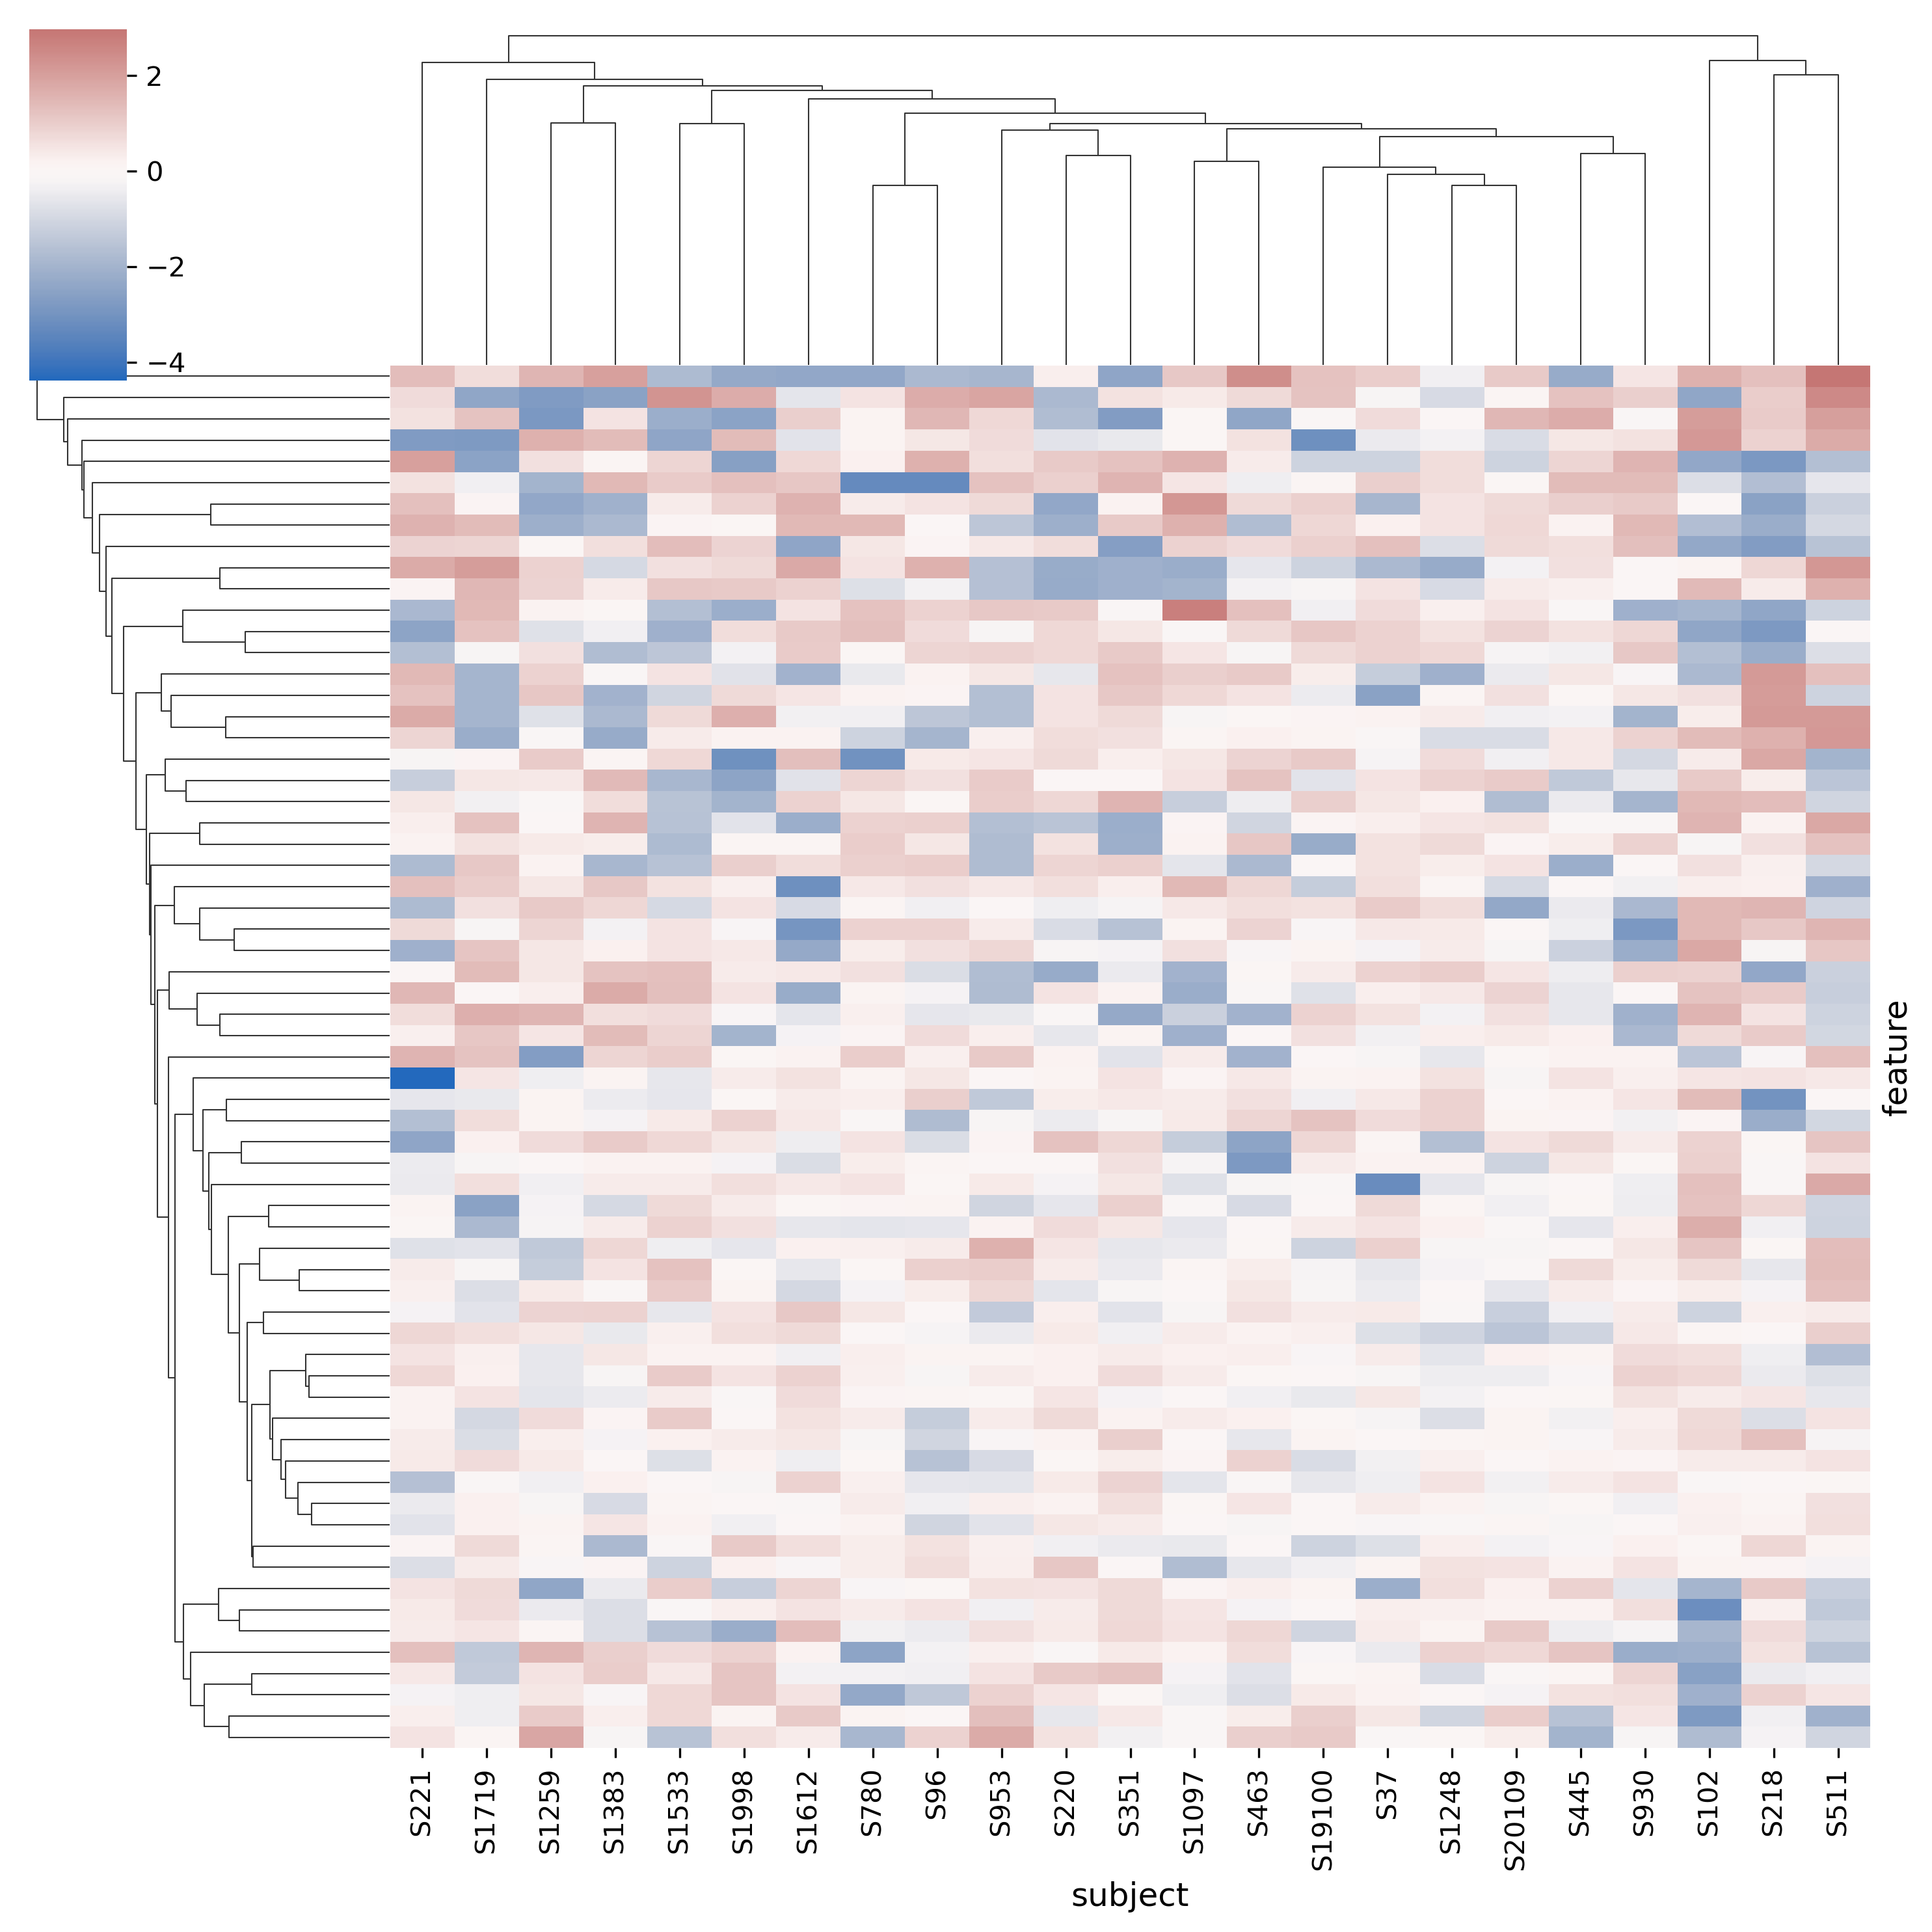

In [30]:
g = sns.clustermap(subj_re_df, yticklabels=False, cmap="vlag", center=0)
plt.show()

We do see that microbial abundance does vary by subject. By accounting for this, we can hopefully get better estimates for the signal that arises from deworming by accounting for the subject "noise".

That's it for this notebook. There's a lot of possibilities with BIRDMAn depending on your specific experimental design and questions.

For instance, here we decided that each subject should have an individual random intercept, but what if we wanted to see how each microbe changes with each subject? We could augment the model by changing the subject effect parameters to include both random intercepts *and* random slopes. This way, we would assert that the rate of change associated with deworming status may differ between subjects.